In [1]:
import pandas as pd
import numpy as np
voice2 = pd.read_csv('Voice2.csv')
voice_self_recorded = pd.read_csv('SoundData.csv')

X_columns = ['Jitter (local, absolute)', 'Jitter (rap)', 'Jitter (ppq5)', 'Jitter (ddp)', 'Shimmer (local)',
             'Shimmer (local,dB)', 'Shimmer (apq3)', 'Shimmer (apq5)', 'Shimmer (apq11)', 'Shimmer (dda)']
X_recorded_cols = ['jitterAbs', 'jitterRap', 'jitterPPQ5', 'jitterDDP', 'shimmerLocal',
                   'shimmerLocalDB', 'shimmerAPQ3', 'shimmerAPQ5', 'shimmerAPQ11', 'shimmerDDA']

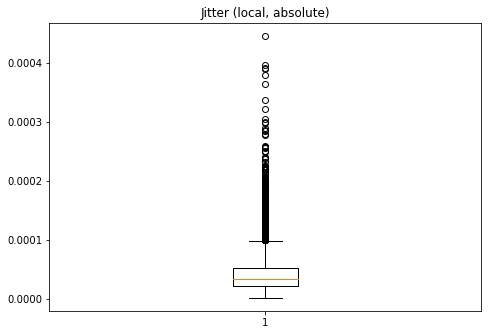

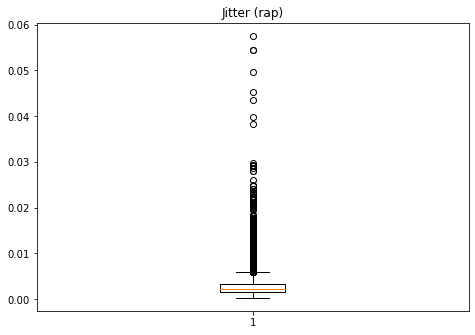

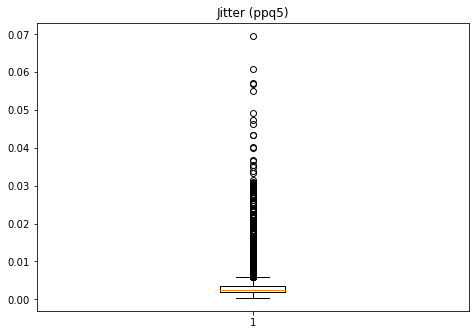

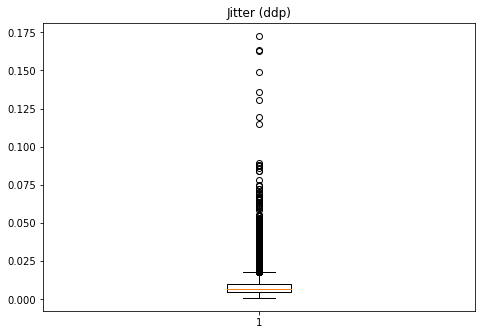

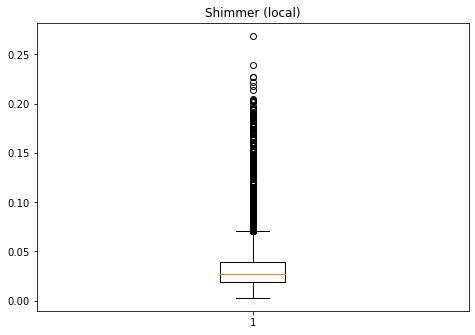

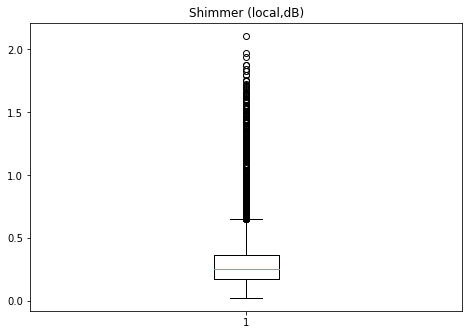

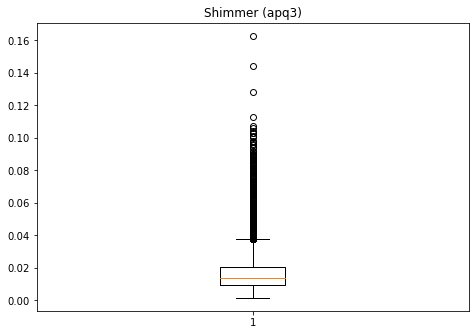

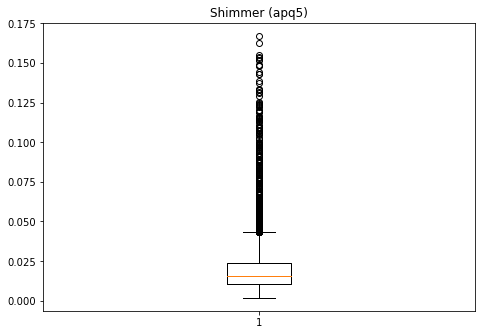

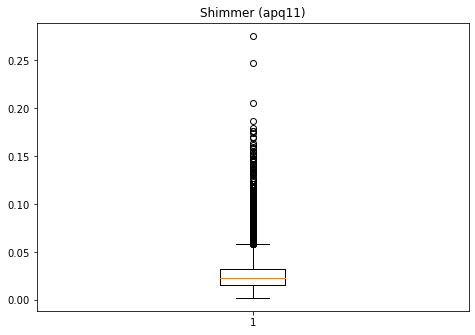

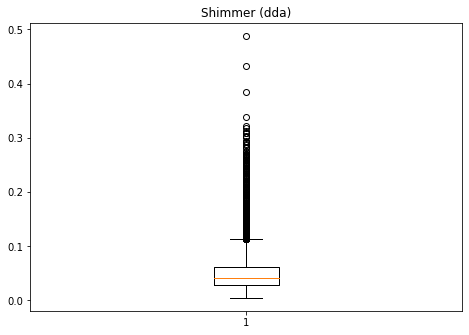

In [2]:
# Data visualization
import matplotlib.pyplot as plt

for col in X_columns:
    data = voice2[col]
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)
    plt.title(col)
    plt.show()

In [6]:
# Data preprocessing
X_standardized = np.empty(shape=[0, len(voice2)])
X2_standardized = np.empty(shape=[0, len(voice_self_recorded)])

for col in X_columns:
    data = voice2[col]
    standardized_col = (data - data.mean()) / data.std()
    X_standardized = np.append(X_standardized, [standardized_col], axis=0)

for col in X_recorded_cols:
    data = voice_self_recorded[col]
    standardized_col = (data - data.mean()) / data.std()
    X2_standardized = np.append(X2_standardized, [standardized_col], axis=0)
    
X_standardized = np.swapaxes(X_standardized, 0, 1)
X2_standardized = np.swapaxes(X2_standardized, 0, 1)

X = np.concatenate((X_standardized, X2_standardized))
Y = pd.concat([voice2.iloc[:, 0], voice_self_recorded['severity']], axis=0)

print(X.shape)
print(Y.shape)
print(X)
print(Y)

(5927, 10)
(5927,)
[[-0.28435508  0.32742464 -0.0286346  ... -0.42332047 -0.54341951
  -0.20968646]
 [-0.79293331 -0.55931048 -0.52172908 ... -0.93100374 -0.90016664
  -0.98528253]
 [-0.64841928 -0.40245119 -0.43597352 ... -0.81818523 -0.82311326
  -0.87674944]
 ...
 [-0.91674949 -0.72056624 -0.85876036 ...  0.19104978  0.41695562
   0.74837007]
 [ 1.21166218  0.49570281  0.74677564 ... -0.69307061 -0.56912684
  -0.28459331]
 [ 0.45418991 -0.0584042  -0.03042089 ...  1.16136327 -0.22309694
   1.15456448]]
0     3
1     3
2     3
3     3
4     3
     ..
47    1
48    1
49    1
50    1
51    1
Length: 5927, dtype: int64


In [7]:
unique, counts = np.unique(Y, return_counts=True)
print(dict(zip(unique, counts)))

# Random Oversampling
import random

num_cats = X.shape[1]
max_count = max(counts)

df = pd.DataFrame(X)
df['label'] = Y.values

df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3]

random.seed(100)
sample_indexes_1 = random.choices(range(len(df_1)), k=max_count)
df_1_resampled = np.empty(shape=[0, num_cats])
for i in sample_indexes_1:
    df_1_resampled = np.append(df_1_resampled, [df_1.iloc[i, :num_cats]], axis=0)

sample_indexes_3 = random.choices(range(len(df_3)), k=max_count)
df_3_resampled = np.empty(shape=[0, num_cats])
for i in sample_indexes_3:
    df_3_resampled = np.append(df_3_resampled, [df_3.iloc[i, :num_cats]], axis=0)

X_resampled = np.empty(shape=[0, num_cats])
X_resampled = np.append(X_resampled, df_1_resampled, axis=0)
X_resampled = np.append(X_resampled, df_2.iloc[:, :num_cats], axis=0)
X_resampled = np.append(X_resampled, df_3_resampled, axis=0)

Y_labels = np.empty(shape=[0])
Y_labels = np.append(Y_labels, [0] * len(df_1_resampled), axis=0)
Y_labels = np.append(Y_labels, [1] * len(df_2), axis=0)
Y_labels = np.append(Y_labels, [2] * len(df_3_resampled), axis=0)

print(X_resampled.shape)
print(Y_labels.shape)
unique, counts = np.unique(Y_labels, return_counts=True)
print(dict(zip(unique, counts)))

{1: 285, 2: 2959, 3: 2683}
(8877, 10)
(8877,)
{0.0: 2959, 1.0: 2959, 2.0: 2959}


In [8]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

batch_size = 32

train_x, test_x, train_y, test_y = train_test_split(X_resampled, Y_labels, test_size = 0.2, random_state = 7)

print(train_y[:5])

train_x = torch.Tensor(train_x)
train_y = F.one_hot(torch.tensor(train_y).to(torch.int64), 3).to(torch.float32)
test_x = torch.Tensor(test_x)
test_y = F.one_hot(torch.tensor(test_y).to(torch.int64), 3).to(torch.float32)

print(train_y[:5])

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

[0. 1. 0. 2. 2.]
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLPCWithDropout(nn.Module):
    def __init__(self, input_size):
        super(MLPCWithDropout, self).__init__()
        self.l1 = nn.Linear(input_size, 100)
        self.l2 = nn.Linear(100, 200)
        self.l3 = nn.Linear(200, 100)
        self.dropout3 = nn.Dropout(0.3)
        self.l5 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.l5(x)
        output = self.softmax(output)
        return output

In [10]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

minValidLoss = np.inf

input_size = X.shape[1]
model = MLPCWithDropout(input_size)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    epochTrainLoss = 0
    for data, labels in train_loader:
        (data, labels) = (data.to(device), labels.to(torch.float32).to(device))
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epochTrainLoss += loss

    print(f'Epoch {epoch} \t\t Training Loss: {epochTrainLoss.item()}')

print("Training complete!")

print(f'Saving Final Model')
torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()
            }, 'voice2_and_recordings_mlpc_121-4L_3D_resampling_CELoss_lr001_500epoch_model.pth')

Epoch 0 		 Training Loss: 228.0692901611328
Epoch 1 		 Training Loss: 223.23277282714844
Epoch 2 		 Training Loss: 221.232177734375
Epoch 3 		 Training Loss: 218.925048828125
Epoch 4 		 Training Loss: 216.3723907470703
Epoch 5 		 Training Loss: 214.73464965820312
Epoch 6 		 Training Loss: 212.75018310546875
Epoch 7 		 Training Loss: 211.1162872314453
Epoch 8 		 Training Loss: 209.80372619628906
Epoch 9 		 Training Loss: 208.48492431640625
Epoch 10 		 Training Loss: 207.32418823242188
Epoch 11 		 Training Loss: 205.83834838867188
Epoch 12 		 Training Loss: 204.7063446044922
Epoch 13 		 Training Loss: 203.3143768310547
Epoch 14 		 Training Loss: 202.7994842529297
Epoch 15 		 Training Loss: 201.58265686035156
Epoch 16 		 Training Loss: 200.56832885742188
Epoch 17 		 Training Loss: 199.42202758789062
Epoch 18 		 Training Loss: 198.74659729003906
Epoch 19 		 Training Loss: 197.4219970703125
Epoch 20 		 Training Loss: 196.8119659423828
Epoch 21 		 Training Loss: 196.1355743408203
Epoch 22 		

Epoch 179 		 Training Loss: 163.8953094482422
Epoch 180 		 Training Loss: 163.92440795898438
Epoch 181 		 Training Loss: 164.09393310546875
Epoch 182 		 Training Loss: 163.77850341796875
Epoch 183 		 Training Loss: 163.94515991210938
Epoch 184 		 Training Loss: 164.31463623046875
Epoch 185 		 Training Loss: 164.25843811035156
Epoch 186 		 Training Loss: 164.08624267578125
Epoch 187 		 Training Loss: 165.22869873046875
Epoch 188 		 Training Loss: 166.58639526367188
Epoch 189 		 Training Loss: 167.80970764160156
Epoch 190 		 Training Loss: 165.8773651123047
Epoch 191 		 Training Loss: 163.58258056640625
Epoch 192 		 Training Loss: 165.9595489501953
Epoch 193 		 Training Loss: 163.89425659179688
Epoch 194 		 Training Loss: 163.40005493164062
Epoch 195 		 Training Loss: 163.08853149414062
Epoch 196 		 Training Loss: 163.0079345703125
Epoch 197 		 Training Loss: 164.26437377929688
Epoch 198 		 Training Loss: 163.18704223632812
Epoch 199 		 Training Loss: 163.2855224609375
Epoch 200 		 Train

Epoch 355 		 Training Loss: 155.8885955810547
Epoch 356 		 Training Loss: 156.32559204101562
Epoch 357 		 Training Loss: 157.52064514160156
Epoch 358 		 Training Loss: 157.2634735107422
Epoch 359 		 Training Loss: 156.5404510498047
Epoch 360 		 Training Loss: 155.89166259765625
Epoch 361 		 Training Loss: 159.21693420410156
Epoch 362 		 Training Loss: 159.3216094970703
Epoch 363 		 Training Loss: 157.1988525390625
Epoch 364 		 Training Loss: 155.69418334960938
Epoch 365 		 Training Loss: 154.74124145507812
Epoch 366 		 Training Loss: 157.0832061767578
Epoch 367 		 Training Loss: 156.84091186523438
Epoch 368 		 Training Loss: 155.4773712158203
Epoch 369 		 Training Loss: 156.50523376464844
Epoch 370 		 Training Loss: 155.83746337890625
Epoch 371 		 Training Loss: 159.71316528320312
Epoch 372 		 Training Loss: 158.51564025878906
Epoch 373 		 Training Loss: 155.44015502929688
Epoch 374 		 Training Loss: 156.4444580078125
Epoch 375 		 Training Loss: 155.40493774414062
Epoch 376 		 Training

Train Loss: 0.689149

Train Accuracy of     0: 90% (2141/2363)
Train Accuracy of     1: 83% (1967/2359)
Train Accuracy of     2: 83% (1961/2350)

Train Accuracy (Overall): 85% (6069/7072)


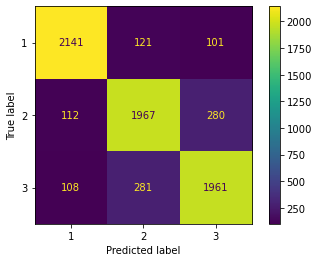

In [11]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
NUM_CLASSES = 3

train_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []

model.eval()

for i, (x, y) in enumerate(train_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	train_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

for i in range(NUM_CLASSES):
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
        i, 100.0 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

# #metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


Test Loss: 0.787261

Test Accuracy of     0: 90% (532/585)
Test Accuracy of     1: 62% (364/584)
Test Accuracy of     2: 72% (427/591)

Test Accuracy (Overall): 75% (1323/1760)


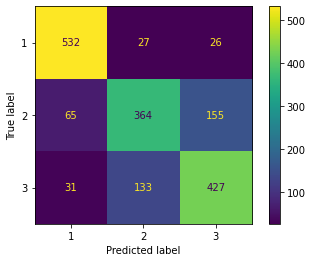

In [12]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

test_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []
model.eval()

for i, (x, y) in enumerate(test_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	test_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(NUM_CLASSES):
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100.0 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

# #metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import numpy as np

class MLPCWithDropout(nn.Module):
    def __init__(self, input_size):
        super(MLPCWithDropout, self).__init__()
        self.l1 = nn.Linear(input_size, 100)
        self.l2 = nn.Linear(100, 200)
        self.l3 = nn.Linear(200, 100)
        self.dropout3 = nn.Dropout(0.3)
        self.l5 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.l5(x)
        output = self.softmax(output)
        return output

num_cols = 10
model = MLPCWithDropout(num_cols)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

file_path = './voice2_and_recordings_mlpc_121-4L_3D_resampling_CELoss_lr001_500epoch_model.pth'

checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLPCWithDropout(
  (l1): Linear(in_features=7, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=100, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (l5): Linear(in_features=100, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)